# Finding Lane Lines on the Road

***
In this project, I used Python and OpenCV to find lane lines in the road images.

The following techniques are used:

* Color Selection
* Canny Edge Detection
* Region of Interest Selection
* Hough Transform Line Detection

Finally, I applied all the techniques to process video clips to find lane lines in them.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os, glob
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


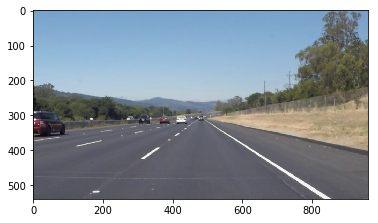

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Display multiple Images

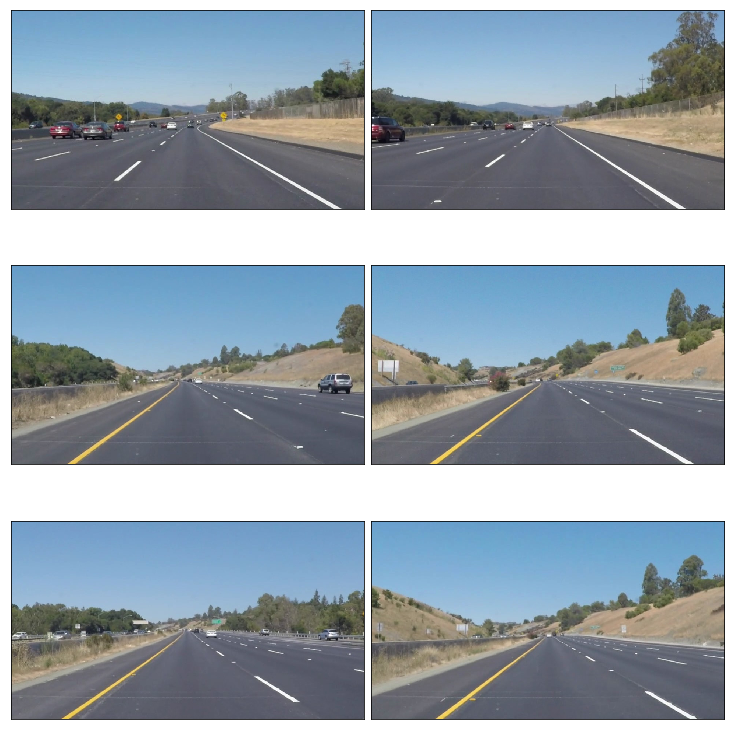

In [3]:
def display_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

display_images(test_images)

## Gray Scaling

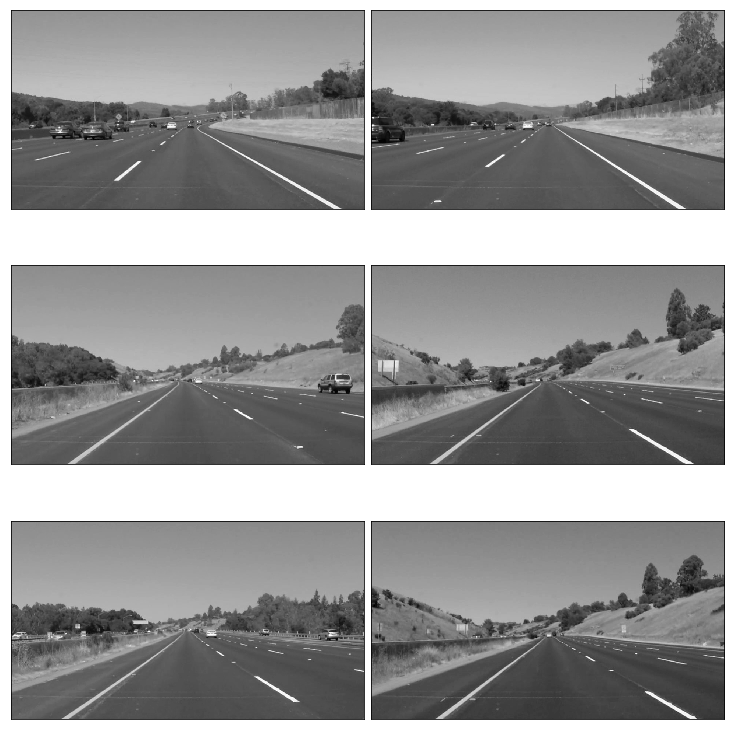

In [4]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray_images = list(map(grayscale, test_images))

display_images(gray_images)

## Gaussian Smoothing

---
When there is an edge (i.e. a line), the pixel intensity changes rapidly (i.e. from 0 to 255) which we want to detect. But before doing so, we should make the edges smoother. As you can see, the above images have many rough edges which causes many noisy edges to be detected.


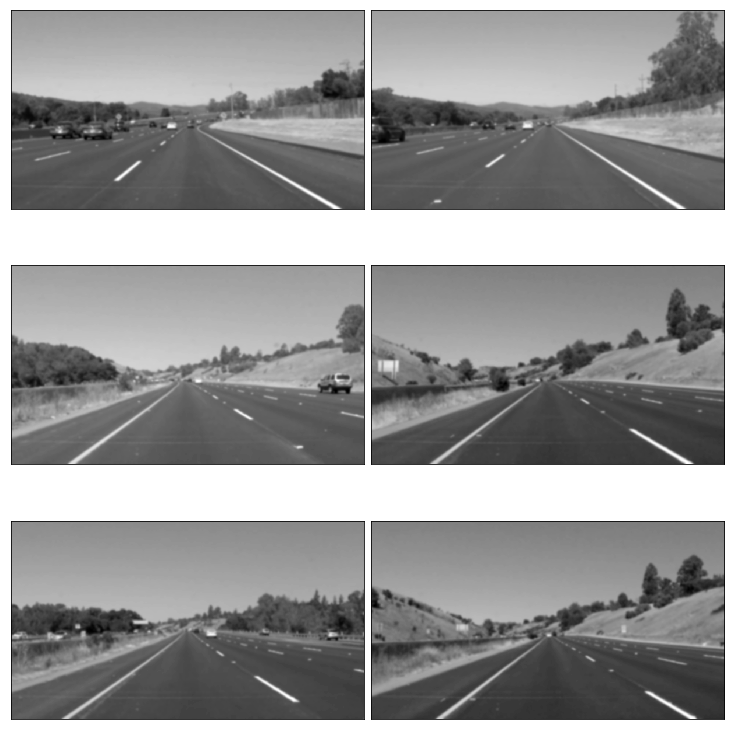

In [5]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

blurred_images = list(map(lambda image: gaussian_blur(image, 13), gray_images))

display_images(blurred_images)

## Edge Detection
I used Canny Edge Detection algorithm [Canny Edge Detection OpenCV Theory](https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)

cv2.Canny(img, low_threshold, high_threshold)

***
If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
If a pixel gradient value is below the lower threshold, then it is rejected.
If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
Canny recommended a upper:lower ratio between 2:1 and 3:1.
These two threshold values are empirically determined. Basically, you will need to define them by trials and errors.

I first set the low_threshold to zero and then adjust the high_threshold. If high_threshold is too high, you find no edges. If high_threshold is too low, you find too many edges. Once you find a good high_threshold, adjust the low_threshold to discard the weak edges (noises) connected to the strong edges.

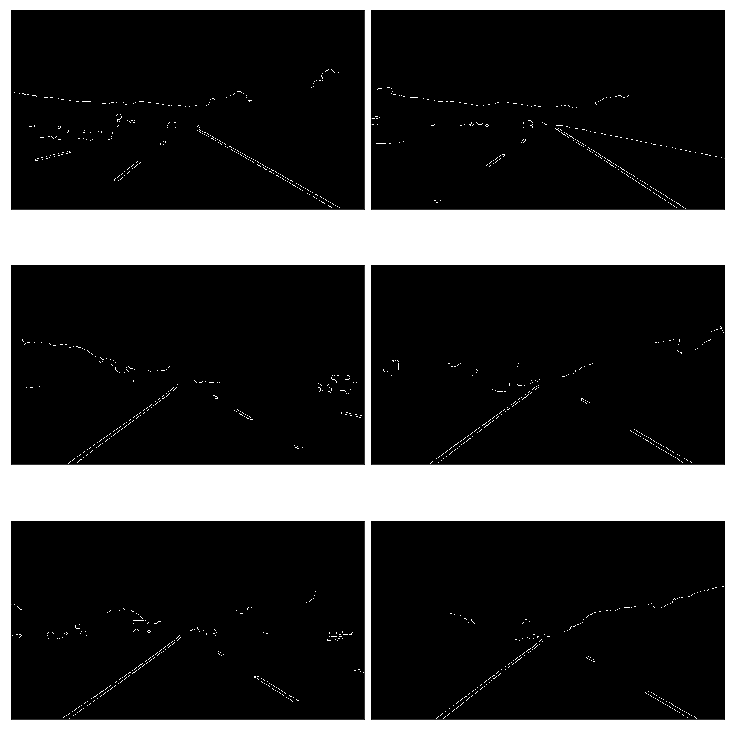

In [6]:
def canny(img, low_threshold=50, high_threshold=150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

edge_images = list(map(lambda image: canny(image), blurred_images))

display_images(edge_images)

## Region of Interest Selection

When finding lane lines, we don't need to check the sky and the hills. We just exclude outside the region of interest by applying a mask.

[cv2.fillPoly OpenCV API Reference](https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#fillpoly)

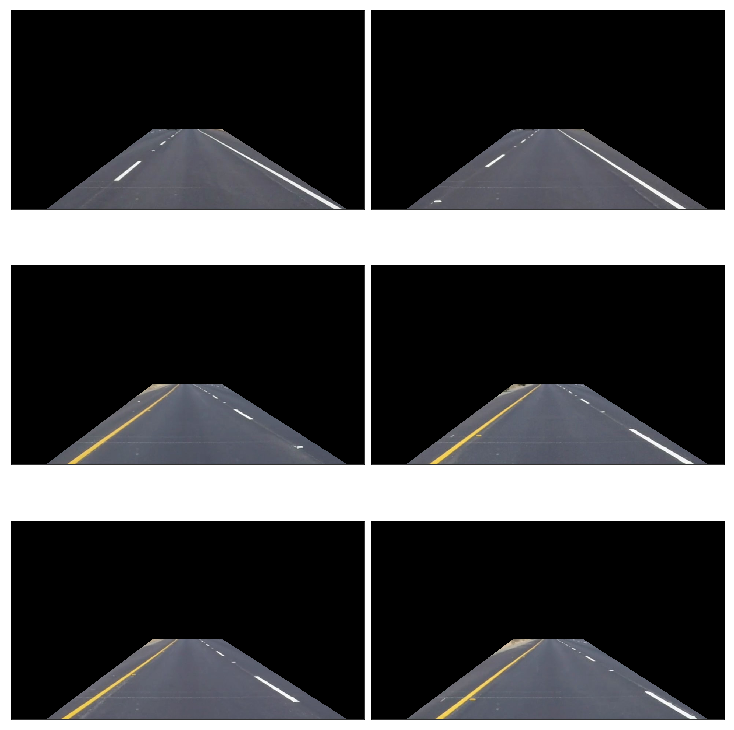

In [15]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def select_region(image):
    """
    It creates masked edges using trapezoid-shaped region-of-interest.  
    Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols   = image.shape[:2]
    bottom_left  = [cols*0.1, rows*1.]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.95, rows*1.]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return region_of_interest(image, vertices)

# images showing the region of interest only
sample_roi_images = list(map(lambda image: select_region(image), test_images))
roi_images = list(map(lambda image: select_region(image), edge_images))

display_images(sample_roi_images)

Now we have lane lines but we need to recognize them as lines. Especially, two lines: the left lane and the right lane.

## Hough Transform Line Detection
I'm using [cv2.HoughLinesP](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#houghlinesp) to detect lines in the edge images.

There are several parameters you'll need to tweak and tune:

* rho – Distance resolution of the accumulator in pixels.
* theta – Angle resolution of the accumulator in radians.
* threshold – Accumulator threshold parameter. Only those lines are returned that get enough votes (> threshold).
* minLineLength – Minimum line length. Line segments shorter than that are rejected.
* maxLineGap – Maximum allowed gap between points on the same line to link them.


In [31]:
# Define the Hough transform parameters

rho = 2                # distance resolution in pixels of the Hough grid
theta = 1 * np.pi/180  # angular resolution in radians of the Hough grid
threshold = 20         # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50   # minimum number of pixels making up a line
max_line_gap = 300     # maximum gap in pixels between connectable line segments

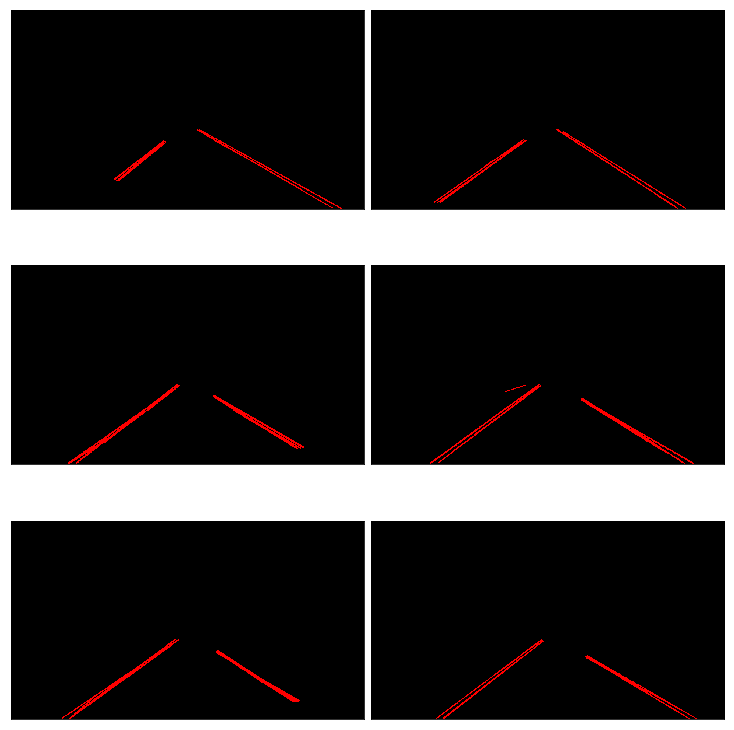

In [9]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    
    return image

def hough_lines(img):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
#     line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    return lines


list_of_lines = list(map(lambda image: hough_lines(image), roi_images))

line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
display_images(line_images)

## Now, let's combine our original image with hough line image

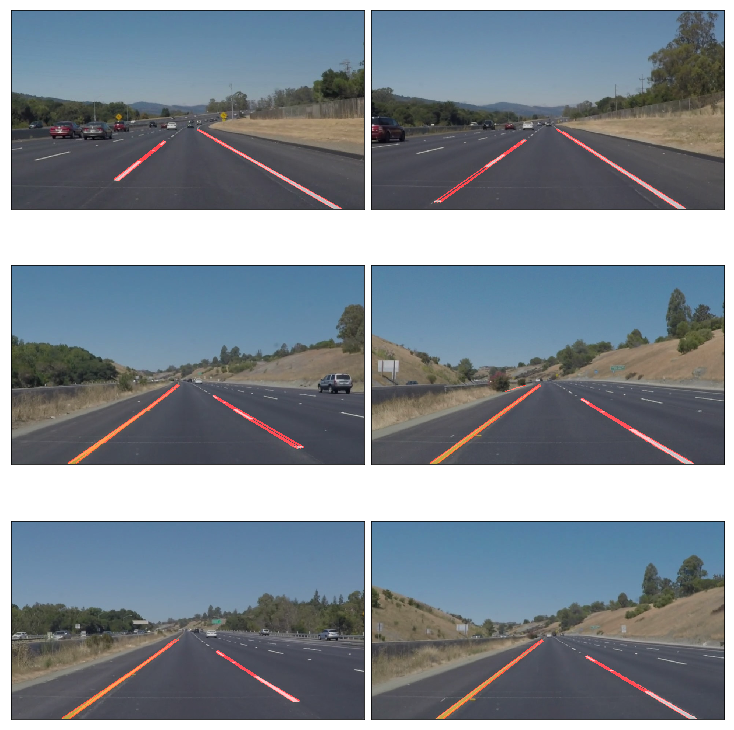

In [17]:
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

final_outp = []
for initial_img, img in zip(test_images, line_images):
    final_outp.append(weighted_img(img, initial_img))

display_images(final_outp)

## Build a Lane Finding Pipeline



Let's combine all stuffs here and run through all test images.

In [18]:
def detectLaneLine(image_in):
    image = mpimg.imread((os.path.join('test_images', image_in)))
    
    gray = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 13
    blur_gray = gaussian_blur(gray, kernel_size)
    
    edges = canny(blur_gray)
    
    masked_edges = select_region(edges)
    
    list_of_lines = hough_lines(masked_edges)
    
    # Draw the lines on the edge image
    lines = draw_lines(image, list_of_lines)
    
    annotated_image = weighted_img(lines, image)
    
    return annotated_image

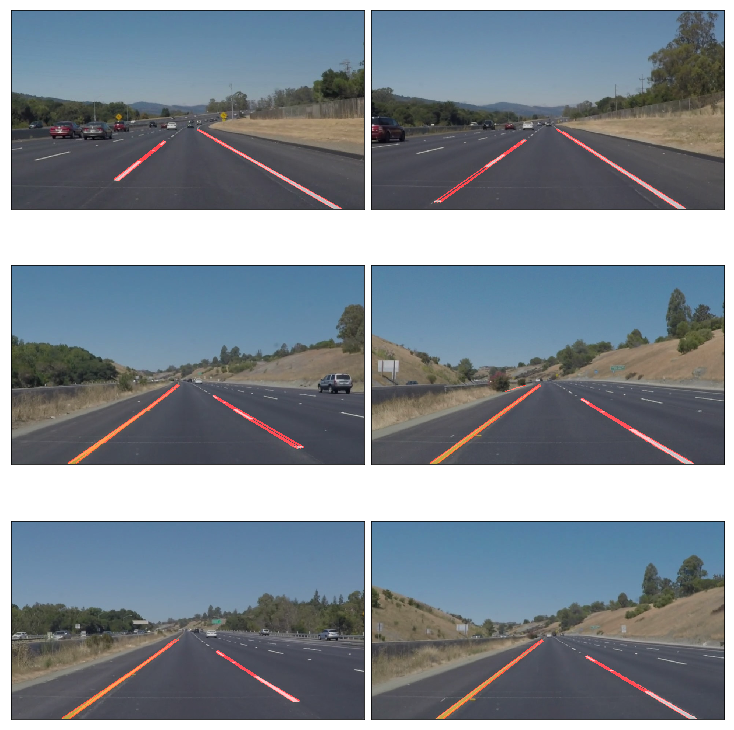

In [34]:
# Finding laneline on all the images in test_images directoryAnnotate all test_images/*.jpg
# Save the annotated images as test_images_output/<original_filename>.jpg
images_with_break_lanes = []
testimages = os.listdir('test_images/')
test_output_images = 'test_images_output'
if not os.path.exists(test_output_images):
    os.makedirs(test_output_images)

for image in testimages:
    if image.endswith("jpg"):
        annotated_image = detectLaneLine(image)
        fname = image.split('.')[0] + '.jpg'  
        plt.imsave(os.path.join(test_output_images, fname), annotated_image)
        images_with_break_lanes.append(annotated_image)

display_images(images_with_break_lanes)

## Averaging and Extrapolating Lines

There are multiple lines detected for a lane line. We should come up with an averaged line for that.

Also, some lane lines are only partially recognized. We should extrapolate the line to cover full lane line length.

We want two lane lines: one for the left and the other for the right. The left lane should have a positive slope, and the right lane should have a negative slope. Therefore, we'll collect positive slope lines and negative slope lines separately and take averages.

Note: in the image, y coordinate is reversed. The higher y value is actually lower in the image. Therefore, the slope is negative for the left lane, and the slope is positive for the right lane.

In [32]:
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane.  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    img = np.zeros_like(image)
    
    # define the boolean for checking the error
    is_right_available = True
    is_left_available = True
    
    # Find the slopes for the all lines and only care about lines where abs(slope) > slope_threshold
    slope_threshold = 0.5
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]
        
        # Calculate slope
        if x2 - x1 == 0.:  # avoiding division by 0
            slope = 999.  # infinite slope
        else:
            slope = (y2 - y1) / (x2 - x1)
            
        # Filter lines according to slope
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
        
    lines = new_lines
    
    # Split lines into right_lines and left_lines, representing the right and left lane lines 
    # Right/left lane lines must have positive/negative slope, and be on the right/left half of the image
    right_lines_x = []
    right_lines_y = []
    left_lines_x  = []
    left_lines_y  = []
    
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] // 2  # x coordinate of center of image
        if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
            right_lines_x.append(x1)
            right_lines_x.append(x2)
            right_lines_y.append(y1)
            right_lines_y.append(y2)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            left_lines_x.append(x1)
            left_lines_x.append(x2)
            left_lines_y.append(y1)
            left_lines_y.append(y2)
            
    # Run linear regression to find best fit line for right and left lane 
    
    # Right lane lines slope and intercept
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = m*x + b
    else:
        right_m, right_b = 1, 1
        is_right_available = False
        
    # Left lane lines slope and intercept
    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  # y = m*x + b
    else:
        left_m, left_b = 1, 1
        is_left_available = False
    
    # Find two end points for right and left lines, used for drawing the line
    y1 = img.shape[0]
    y2 = img.shape[0] * 0.62
    
    right_x1 = (y1 - right_b) / right_m
    right_x2 = (y2 - right_b) / right_m
    
    left_x1 = (y1 - left_b) / left_m
    left_x2 = (y2 - left_b) / left_m
    
    # Convert calculated end points from float to int to find pixel value
    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
    
    # Draw the right and left lines on image
    if is_right_available:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if is_left_available:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)
        
    return weighted_img(img, image)

In [33]:
def detectTwoSingleLanes(image_in):
    
    gray = grayscale(image_in)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 13
    blur_gray = gaussian_blur(gray, kernel_size)
    
    edges = canny(blur_gray)
    
    masked_edges = select_region(edges)
    
    lines = hough_lines(masked_edges)
    
    return draw_lane_lines(image_in, lines)

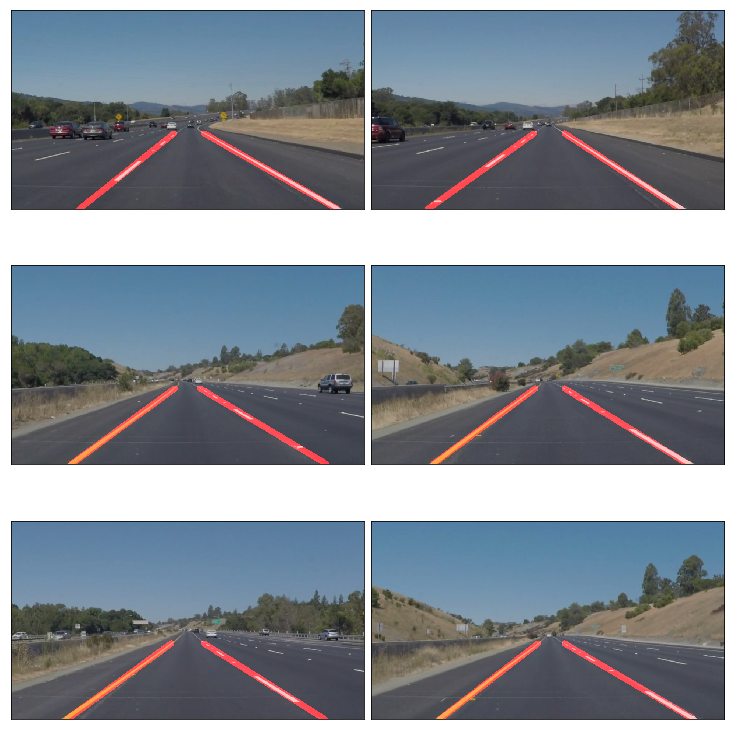

In [35]:
# Finding laneline on all the images in test_images directory.
# Save the annotated images as test_images_output/<original_filename>_new.jpg
images_with_two_lanes = []
testimages = os.listdir('test_images/')
test_output_images = 'test_images_output'
if not os.path.exists(test_output_images):
    os.makedirs(test_output_images)
    
for image in testimages:
    if image.endswith("jpg"):
        annotated_image = detectTwoSingleLanes(mpimg.imread(os.path.join('test_images', image)))
        fname = image.split('.')[0] + '_new.jpg'  
        plt.imsave(os.path.join(test_output_images, fname), annotated_image)
        images_with_two_lanes.append(annotated_image)

display_images(images_with_two_lanes)

## Drawing Lanes on Videos

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    
    return detectTwoSingleLanes(image)

Let's try the one with the solid white lane on the right first ...

In [25]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 38.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 13.1 s, sys: 500 ms, total: 13.6 s
Wall time: 6.16 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [27]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,10)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:22<00:00, 29.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 45.6 s, sys: 1.61 s, total: 47.2 s
Wall time: 23 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [29]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:11<00:00, 22.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 18.9 s, sys: 490 ms, total: 19.4 s
Wall time: 12.4 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))